# Random Forest Regressor

---

**Источники:**

[sklearn.ensemble.RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

[1.11.2. Forests of randomized trees](https://scikit-learn.org/stable/modules/ensemble.html#forest)


[Random Forest Regression](https://medium.com/swlh/random-forest-and-its-implementation-71824ced454f)

[Painless Random Forest Regression in Python – Step-by-Step with Sklearn](https://onestopdataanalysis.com/python-random-forest-regression/)

[Random forest](https://ru.wikipedia.org/wiki/Random_forest)

[Бэггинг](https://ru.wikipedia.org/wiki/%D0%91%D1%8D%D0%B3%D0%B3%D0%B8%D0%BD%D0%B3)

[How to Visualize a Decision Tree from a Random Forest in Python using Scikit-Learn](https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c)

---


## Подготовка окружения

In [1]:
# ВНИМАНИЕ: необходимо удостовериться, что виртуальная среда выбрана правильно!

# Для MacOS/Ubuntu
# !which pip

# Для Windows
# !where pip

In [2]:
# !conda install matplotlib numpy scikit-learn seaborn -y

In [3]:
# !conda install -c conda-forge shap -y

In [4]:
import scipy
from scipy import stats

scipy.__version__

'1.6.2'

In [5]:
import numpy as np

np.__version__

'1.20.2'

In [6]:
import pandas as pd

pd.__version__

'1.2.4'

In [7]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.__version__

'3.3.4'

In [8]:
import seaborn as sns

sns.__version__

'0.11.1'

In [9]:
import shap

shap.__version__

'0.39.0'

In [10]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

## Загрузка данных

[Источник (Calculate Concrete Strength)](https://www.kaggle.com/prathamtripathi/regression-with-neural-networking)

In [11]:
df = pd.read_csv("./../../data/concrete_data.csv")
df

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


## Разделение данных на `X` и `y`

In [12]:
target = 'Strength'

In [13]:
from sklearn.model_selection import train_test_split

y = df[target].copy()
X = df.drop(columns=[target]).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Random Forest (Случайный лес) Regressor

[sklearn.ensemble.RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

Основная идея заключается в использовании большого **ансамбля решающих деревьев (decision tree)**, каждое из которых само по себе даёт очень невысокое качество, но за счёт их большого количества результат получается хорошим.

Алгоритм применяется для задач **классификации, регрессии и кластеризации**.

**Достоинства:**
- Способность эффективно обрабатывать данные с большим числом признаков и классов.
- Нечувствительность к масштабированию (и вообще к любым монотонным преобразованиям) значений признаков.
- Одинаково хорошо обрабатываются как непрерывные, так и дискретные признаки. Существуют методы построения деревьев по данным с пропущенными значениями признаков.
- Существуют методы оценивания значимости отдельных признаков в модели.
- Внутренняя оценка способности модели к обобщению (тест по неотобранным образцам out-of-bag).
- Высокая параллелизуемость и масштабируемость.

**Недостатки:**
- Большой размер получающихся моделей. Требуется $O(K)$ памяти для хранения модели, где $K$ — число деревьев.

<center><img src="images/random_forest.png"/></center>

---

<center><img src="images/random_forest_2.png"/></center>

<center><img src="images/random_forest_regression_line.png"/></center>

## Анализ и обработка выбросов

In [14]:
def remove_outliers_iqr(data, col_name):
    print(f"column name: {col_name}\n")
    Q1 = data[col_name].quantile(0.25)
    Q3 = data[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    data_new = data[~((data[col_name] < lower_fence) |
                      (data[col_name] > upper_fence))]
    
    diff_len = len(data) - len(data_new)
    print(f"removed: {diff_len}")
    
    _, axs = plt.subplots(1, 2, figsize=(10, 2))
    sns.boxplot(data=data_new[col_name], ax=axs[0])
    sns.histplot(data=data_new[col_name], ax=axs[1])
    
    return data_new.reset_index(drop=True)

## Анализ числовых признаков

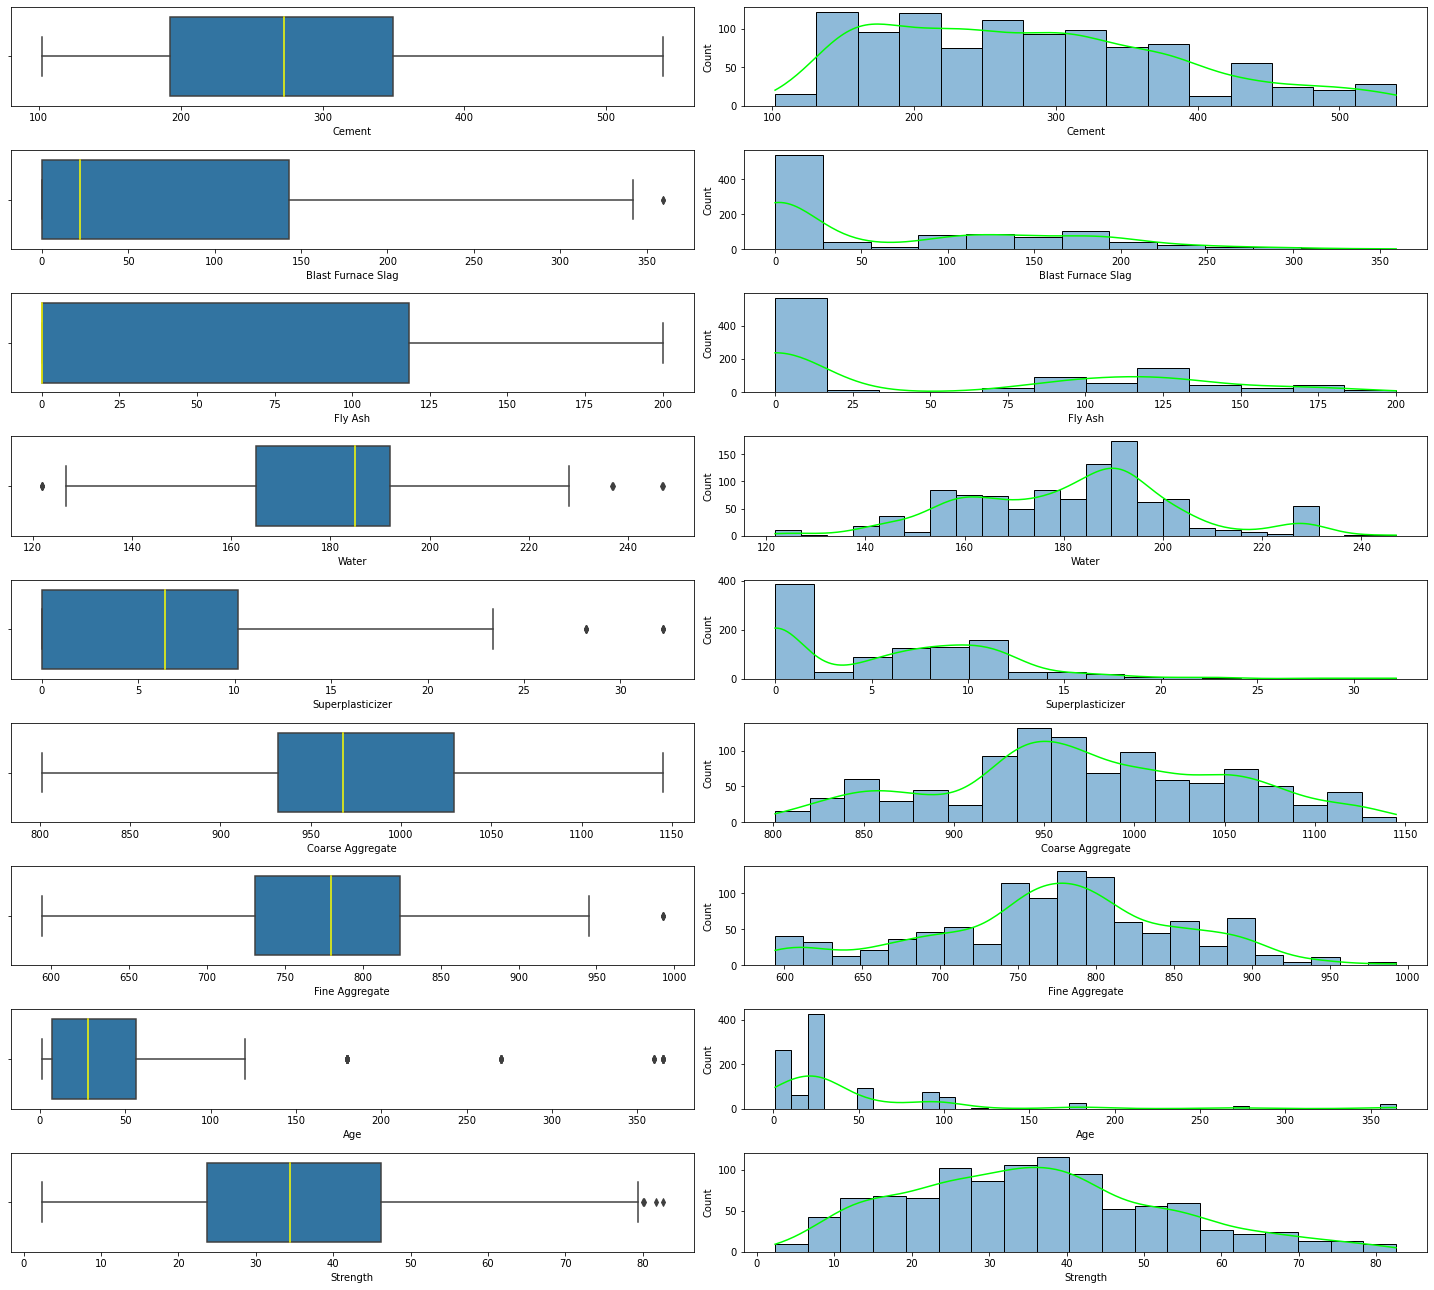

In [15]:
num_cols = df.select_dtypes(include=np.number).columns.to_list()
fig, axs = plt.subplots(len(num_cols), 2, figsize=(20, 2 * len(num_cols)))

for index, column_name in enumerate(num_cols):
    sns.boxplot(x=df[column_name], ax=axs[index][0])
    axs[index][0].get_lines()[4].set_color('yellow')
    
    sns.histplot(x=df[column_name], kde=True, ax=axs[index][1])
    axs[index][1].get_lines()[0].set_color('lime')
    
fig.tight_layout(pad=1.0)

## Анализ корреляций

In [16]:
corr = X.corr(method='spearman')
corr

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
Cement,1.000000,-0.245167,-0.418320,-0.094437,0.037919,-0.144880,-0.173596,0.004640
Blast Furnace Slag,-0.245167,1.000000,-0.253551,0.053360,0.098137,-0.348898,-0.302278,-0.017581
Fly Ash,-0.418320,-0.253551,1.000000,-0.283150,0.454091,0.058366,0.051307,0.002801
Water,-0.094437,0.053360,-0.283150,1.000000,-0.686923,-0.218487,-0.345614,0.090942
Superplasticizer,0.037919,0.098137,0.454091,-0.686923,1.000000,-0.198802,0.168313,-0.009525
Coarse Aggregate,-0.144880,-0.348898,0.058366,-0.218487,-0.198802,1.000000,-0.100480,-0.044928
Fine Aggregate,-0.173596,-0.302278,0.051307,-0.345614,0.168313,-0.100480,1.000000,-0.057362
Age,0.004640,-0.017581,0.002801,0.090942,-0.009525,-0.044928,-0.057362,1.000000


<AxesSubplot:>

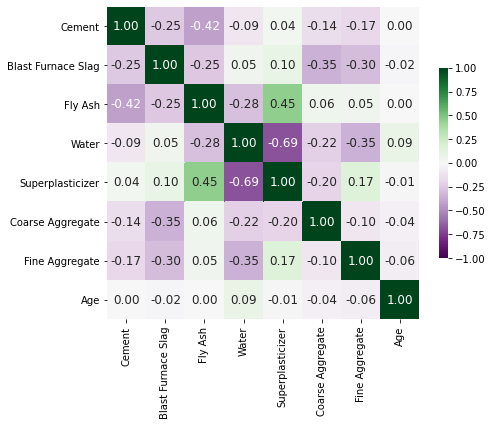

In [17]:
plt.figure(figsize=(7, 7))

sns.heatmap(corr, 
            square=True,
            annot=True,
            fmt='.2f',
            cmap='PRGn',
            cbar_kws={"shrink": .5},
            annot_kws={"size": 12},
            robust=True,
            vmin=-1, 
            vmax=1)

## Анализ отсутствующих значений

In [18]:
X.isna().sum()

Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
dtype: int64

In [19]:
y.isna().sum()

0

Выводы: Отсутствующих значений нет.

## Важные параметры [sklearn.ensemble.RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

- `n_estimators: int, default=100`
    - Количество деревьев в лесу.
    
    
- `criterion: {"mse", "mae"}, default="mse"`
    - Функция измерения качества разделения.
    - Поддерживаемые критерии: `"mse"` для среднеквадратичной ошибки, которая равна уменьшению дисперсии в качестве критерия выбора признаков, и `"mae"` для средней абсолютной ошибки.
    
    
- `max_depth: int, default=None`
    - Максимальная глубина дерева.
    - Если `None`, то узлы расширяются до тех пор, пока все листья не станут чистыми или пока все листья не будут содержать менее `min_samples_split` выборок.
    
   
- `min_samples_split: int или float, default=2`
    - Минимальное количество выборок, необходимое для разделения внутреннего узла:
        - Если `int`, то считает `min_samples_split` минимальным числом.
        - Если `float`, то `min_samples_split` - это дробь, а `ceil(min_samples_split * n_samples)` - минимальное количество выборок для каждого разделения.
        
        
- `min_samples_leaf: int or float, default=1`
    - Минимальное количество выборок, которое требуется для конечного узла.
    - Точка разделения на любой глубине будет учитываться только в том случае, если она оставляет не менее `min_samples_leaf` обучающих выборок в каждой из левой и правой ветвей. Это может иметь эффект сглаживания модели, особенно при регрессии.
    - Если `int`, то считает `min_samples_leaf` минимальным числом.
    - Если `float`, то `min_samples_leaf` - дробная часть, а `ceil(min_samples_leaf * n_samples)` - минимальное количество выборок для каждого узла.
    
    
- `min_weight_fraction_leaf: float, default=0.0`


- `max_features: {"auto", "sqrt", "log2"}, int or float, default="auto"`


- `max_leaf_nodes: int, default=None`
    - Выращиевает деревья с `max_leaf_nodes` способом "лучший первый" (best-first).
    - Лучшие узлы определяются как относительное уменьшение "загрязнения" (impurity).
    - Если `None`, то неограниченное количество конечных узлов.

## Обучение модели (Train) - manual

In [20]:
# импортировать пакет RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# создать объект RandomForestRegressor
model = RandomForestRegressor(n_estimators=10, 
                              max_depth=5)

# обучить модель
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=10)

## Оценка качества модели (Evaluation)

In [21]:
# использовать обученную модель для предсказания на test выборке
y_test_predicted = model.predict(X_test)
y_train_predicted = model.predict(X_train)

In [22]:
print(f'R2 (train): {r2_score(y_train, y_train_predicted)}')
print(f'R2 (test): {r2_score(y_test, y_test_predicted)}')

print(f"MSE (train): {mean_squared_error(y_train, y_train_predicted, squared=True)}")
print(f"MSE (test): {mean_squared_error(y_test, y_test_predicted, squared=True)}")

R2 (train): 0.8778247164172033
R2 (test): 0.7928293620015061
MSE (train): 33.95584449472105
MSE (test): 57.8452645860154


Для визуализации необходимо установить [`Graphviz`](https://graphviz.gitlab.io/download/).

In [23]:
from sklearn.tree import export_graphviz
import os

for i, est in enumerate(model.estimators_):
    export_graphviz(est,
                    out_file=f'tmp/rf_tree_{i}.dot', 
                    feature_names = X_train.columns.to_list(),
                    class_names = y_train.name,
                    rounded = True, 
                    proportion = False, 
                    precision = 2,
                    special_characters=True,
                    filled = True)
    os.system(f'dot -Tpng tmp/rf_tree_{i}.dot -o tmp/rf_tree_{i}.png')

## Важность признаков

### Важность признаков на основе среднего уменьшения примесей (mean decrease in impurity)

Важность признаков обеспечивается соответствующим атрибутом `feature_importances_`, и они вычисляются как среднее значение и стандартное отклонение накопления уменьшения примесей в каждом дереве.

**ВНИМАНИЕ:** Важность признаков на основе примесей может вводить в заблуждение для **признаков с высокой мощностью** (много уникальных значений).

In [24]:
feature_names = X_train.columns
feature_names

Index(['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer',
       'Coarse Aggregate', 'Fine Aggregate', 'Age'],
      dtype='object')

In [25]:
importances = model.feature_importances_
importances

array([0.33666773, 0.06487111, 0.01073909, 0.15653347, 0.03358906,
       0.01041422, 0.01954646, 0.36763887])

In [26]:
std = np.std([tree.feature_importances_ for tree in model.estimators_], 
             axis=0)

std

array([0.06943658, 0.02532932, 0.01413339, 0.06371081, 0.02179257,
       0.00918734, 0.02255235, 0.03489118])

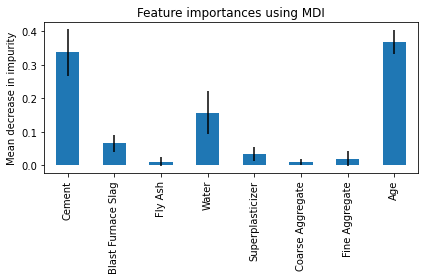

In [27]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Важность признаков на основе перестановки признаков (feature permutation)

Такой подход преодолевает ограничения важности признака на основе примесей: признаки не имеют предвзятости в сторону признаков с высокой мощностью и могут быть вычислены на оставленном наборе тестов.

[sklearn.inspection.permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html)

Вычисление важности полной перестановки **более затратно: признаки перемешиваются `n` раз**, и модель перестраивается, чтобы оценить их важность.

При использовании обоих методов одни и те же признаки определяются как наиболее важные. Хотя относительные значения различаются.

In [28]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=10)

result

{'importances_mean': array([0.53660189, 0.08698987, 0.00670052, 0.15828891, 0.04957464,
        0.00688139, 0.02241057, 0.7289889 ]),
 'importances_std': array([0.04933788, 0.01103586, 0.00174442, 0.02186513, 0.00651932,
        0.00305836, 0.00299483, 0.05802333]),
 'importances': array([[0.53892376, 0.48296435, 0.47840797, 0.50714409, 0.6038411 ,
         0.5089749 , 0.645286  , 0.5387262 , 0.53528489, 0.52646559],
        [0.0791699 , 0.09818117, 0.08985283, 0.08721514, 0.08976316,
         0.08155389, 0.06783644, 0.11101582, 0.08412784, 0.08118251],
        [0.0059762 , 0.00552159, 0.00821088, 0.0036056 , 0.00543806,
         0.0091694 , 0.00827954, 0.0049527 , 0.00746905, 0.00838216],
        [0.18390874, 0.14377089, 0.148523  , 0.12722601, 0.13664523,
         0.18694903, 0.16127568, 0.18637301, 0.17322649, 0.134991  ],
        [0.06311092, 0.04018485, 0.05733381, 0.04991239, 0.05160067,
         0.04641676, 0.04520619, 0.05086901, 0.04193919, 0.04917264],
        [0.00496052, 0.

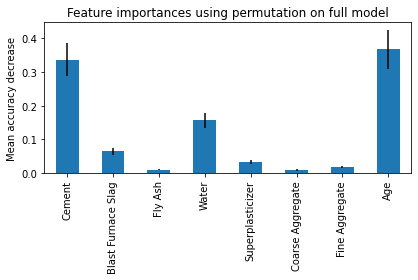

In [29]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()

### [SHAP](https://github.com/slundberg/shap)

TODO

In [30]:
shap.initjs()

In [31]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

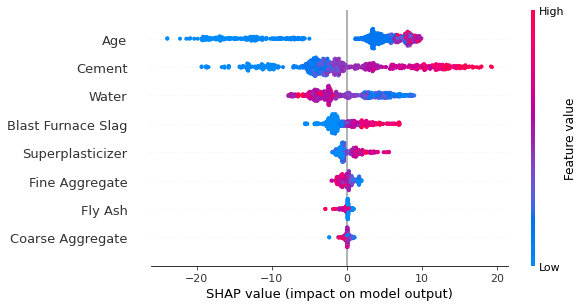

In [33]:
shap.summary_plot(shap_values, X_train)

## Feature Selection

In [36]:
selector = SelectKBest(score_func=mutual_info_regression, k=6).fit(X_train, y_train)

In [37]:
X_train_new = selector.transform(X_train)
X_train_new

array([[ 150. ,  237. ,  174. ,   12. , 1069. ,   28. ],
       [ 218.9,    0. ,  158.5,   11.3, 1078.7,   14. ],
       [ 339. ,    0. ,  197. ,    0. ,  968. ,  365. ],
       ...,
       [ 190.3,    0. ,  166.6,    9.9, 1079. ,  100. ],
       [ 475. ,  118.8,  181.1,    8.9,  852.1,   28. ],
       [ 314. ,    0. ,  170. ,   10. ,  925. ,   28. ]])

In [38]:
feat_scores = pd.DataFrame({'score': selector.scores_}, index=X_train.columns).sort_values(by='score', 
                                                                    ascending=False)

<AxesSubplot:>

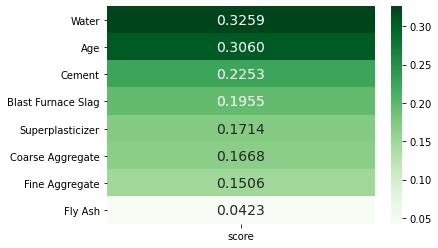

In [39]:
sns.heatmap(feat_scores, annot=True, 
            annot_kws={"size": 14}, 
            fmt="1.4f", 
            cmap='Greens')

## Обучение модели (Train) - pipeline

In [40]:
param_grid = {'model__max_depth': [5, 8, 11], 
              'model__n_estimators': [50, 100], 
              'model__criterion': ["mse", "mae"]}

In [41]:
pipeline = Pipeline(steps = [
#             ('fs', SelectKBest(score_func=f_regression, k=5)),
            ('fs', SelectKBest(score_func=mutual_info_regression, k=6)),

            ('model', RandomForestRegressor())
        ])

In [42]:
model_gs = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', n_jobs=-1)

In [43]:
model_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('fs',
                                        SelectKBest(k=6,
                                                    score_func=<function mutual_info_regression at 0x7fa943eabd30>)),
                                       ('model', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'model__criterion': ['mse', 'mae'],
                         'model__max_depth': [5, 8, 11],
                         'model__n_estimators': [50, 100]},
             scoring='neg_mean_squared_error')

In [44]:
print(f"best_params: {model_gs.best_params_}")
print(f"best_score: {model_gs.best_score_:0.2f}")

best_params: {'model__criterion': 'mse', 'model__max_depth': 11, 'model__n_estimators': 100}
best_score: -28.93


In [45]:
pd.DataFrame(model_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_depth,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.160266,0.035035,0.011133,0.006775,mse,5,50,"{'model__criterion': 'mse', 'model__max_depth'...",-51.101368,-41.201483,-56.714250,-47.631602,-42.829321,-47.895605,5.631938,10
1,0.236418,0.022972,0.013004,0.001075,mse,5,100,"{'model__criterion': 'mse', 'model__max_depth'...",-49.693193,-43.145340,-55.027911,-46.348191,-43.485980,-47.540123,4.424332,9
2,0.147293,0.016271,0.012514,0.009193,mse,8,50,"{'model__criterion': 'mse', 'model__max_depth'...",-33.757808,-31.541106,-41.766503,-28.102088,-27.579767,-32.549455,5.136297,6
3,0.277558,0.033857,0.014004,0.001370,mse,8,100,"{'model__criterion': 'mse', 'model__max_depth'...",-35.716444,-27.857620,-38.367933,-27.932250,-28.004229,-31.575695,4.541683,5
4,0.172168,0.022408,0.009263,0.000475,mse,11,50,"{'model__criterion': 'mse', 'model__max_depth'...",-33.573897,-26.286393,-35.935130,-25.851605,-24.744586,-29.278322,4.561005,2
5,0.283328,0.009013,0.018587,0.008806,mse,11,100,"{'model__criterion': 'mse', 'model__max_depth'...",-33.232229,-26.378232,-34.842607,-25.490394,-24.727372,-28.934167,4.230189,1
6,0.627210,0.063445,0.010749,0.003917,mae,5,50,"{'model__criterion': 'mae', 'model__max_depth'...",-52.195327,-43.866831,-54.967466,-50.162493,-46.731032,-49.584630,3.923285,11
7,1.151871,0.136279,0.019553,0.005980,mae,5,100,"{'model__criterion': 'mae', 'model__max_depth'...",-52.649815,-41.820107,-54.961852,-51.321139,-48.498579,-49.850298,4.526362,12
8,0.892421,0.147048,0.018420,0.007040,mae,8,50,"{'model__criterion': 'mae', 'model__max_depth'...",-38.412129,-31.221463,-40.509028,-31.458492,-27.197129,-33.759648,4.939718,8
9,1.123321,0.134127,0.013109,0.000945,mae,8,100,"{'model__criterion': 'mae', 'model__max_depth'...",-35.525413,-30.595259,-40.049091,-31.066235,-29.806988,-33.408597,3.871697,7


## Оценка качества модели (Evaluation)

In [46]:
y_test_predicted = model_gs.predict(X_test)
y_train_predicted = model_gs.predict(X_train)

In [47]:
print(f'R2 (train): {r2_score(y_train, y_train_predicted)}')
print(f'R2 (test): {r2_score(y_test, y_test_predicted)}')

print(f"MSE (train): {mean_squared_error(y_train, y_train_predicted, squared=True)}")
print(f"MSE (test): {mean_squared_error(y_test, y_test_predicted, squared=True)}")

R2 (train): 0.9811517318119675
R2 (test): 0.8881507902165767
MSE (train): 5.238447948057375
MSE (test): 31.230039141482496
